In [1]:
%%capture --no-stderr
%pip install openslide-python openslide-bin 

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import openslide
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base_dir = "/kaggle/input/prostate-cancer-grade-assessment"
os.listdir(base_dir)

['sample_submission.csv',
 'train_images',
 'train_label_masks',
 'train.csv',
 'test.csv']

In [4]:
train_path = base_dir + '/train.csv'
train_df = pd.read_csv(train_path)

In [5]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
train_df.shape

(10616, 4)

# Description of the columns
1. image_id: ID code for the image.
2. data_provider: The name of the institution that provided the data. Both the Karolinska Institute and Radboud University Medical Center contributed data. They used different scanners with slightly different maximum microscope resolutions and worked with different pathologists for labeling their images.
3. isup_grade: Train only. The target variable. The severity of the cancer on a 0-5 scale.
4. gleason_score: Train only. An alternate cancer severity rating system with more levels than the ISUP scale. For details on how the gleason and ISUP systems compare, see the Additional Resources tab.



## Understanding different severity using isup_grade and gleanson_score

<Axes: xlabel='isup_grade', ylabel='count'>

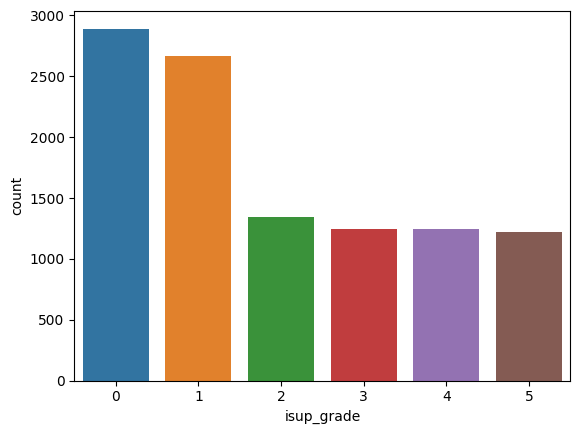

In [7]:
sns.countplot(data = train_df, x = train_df['isup_grade'])

### Explaining the isup grade labels

 0: background (non tissue) or unknown
 
 1: stroma (connective tissue, non-epithelium tissue)
 
 2: healthy (benign) epithelium
 
 3: cancerous epithelium (Gleason 3)
 
 4: cancerous epithelium (Gleason 4)
 
 5: cancerous epithelium (Gleason 5)
on 5)

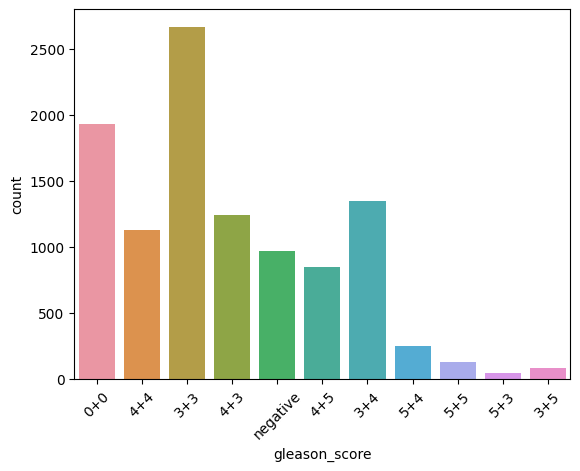

In [8]:
sns.countplot(data = train_df, x = train_df['gleason_score'])
plt.xticks(rotation=45)

plt.show()

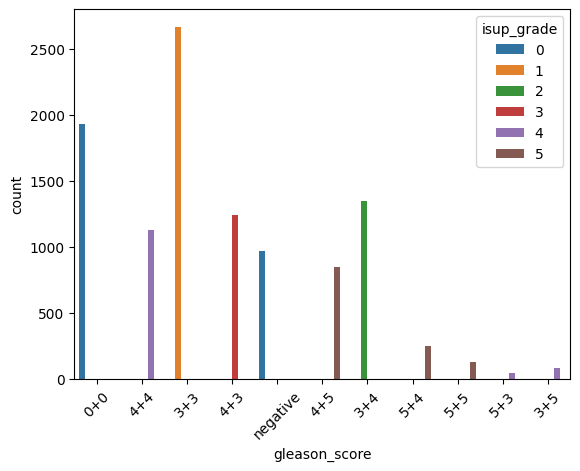

In [9]:
sns.countplot(data = train_df, x = train_df['gleason_score'], hue='isup_grade')
plt.xticks(rotation=45)

plt.show()

In [10]:
train_images_dir = base_dir + '/train_images'
train_df['image_path'] = train_df['image_id'].apply(lambda img_id: os.path.join(train_images_dir, img_id + '.tiff'))

In [11]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,image_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...


In [12]:
train_df['image_path'][0]

'/kaggle/input/prostate-cancer-grade-assessment/train_images/0005f7aaab2800f6170c399693a96917.tiff'

In [13]:
# image sizes
def get_image_size_mb(image_id):
    image_path = os.path.join(train_images_dir, image_id + '.tiff')
    try:
        size_bytes = os.path.getsize(image_path)
        size_mb = size_bytes / (1024 * 1024)  # Convert bytes to MB
        return size_mb
    except Exception as e:
        return None 



In [14]:
train_df['image_size_mb'] = train_df['image_id'].apply(get_image_size_mb)
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,image_path,image_size_mb
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...,44.505790
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...,13.710004
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...,19.913318
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...,47.782884
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...,68.185296


In [15]:
# Let's understand where majority of images belong in size
train_df.describe()

,isup_grade,image_size_mb
count,10616.000000,10616.000000
mean,1.902223,33.441344
std,1.719537,19.107833
min,0.000000,0.778735
25%,0.000000,19.115608
50%,1.000000,30.759668
75%,3.000000,46.155396
max,5.000000,237.936227


The biggest image has ~239MB and the smallest one has ~0.78MB.

In [16]:
# How many images have a maximum size of 5MB?
filtered_size_df = train_df[train_df['image_size_mb'] < 5]
filtered_size_df.shape

(305, 6)

Exactly 305 images have size less than 5 MBs.

In [17]:
filtered_size_df.head()

,image_id,data_provider,isup_grade,gleason_score,image_path,image_size_mb
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,3.207255
155,04063850d065e6fa2d7a479d9eb36870,radboud,1,3+3,/kaggle/input/prostate-cancer-grade-assessment...,3.506133
157,040b2c98538ec7ead1cbd6daacdb3f64,radboud,0,negative,/kaggle/input/prostate-cancer-grade-assessment...,2.813735
181,04cbadfe2c866c2ff16f04b54ea26c33,radboud,5,5+4,/kaggle/input/prostate-cancer-grade-assessment...,3.630179
197,053a397c936bffc98e62367a81d6c905,radboud,1,3+3,/kaggle/input/prostate-cancer-grade-assessment...,2.336350


In [18]:
# image distribution based on the class, isup_grade
filtered_size_df['isup_grade'].value_counts()

isup_grade
4    81
0    74
1    52
5    49
3    34
2    15
Name: count, dtype: int64

<Axes: xlabel='isup_grade', ylabel='count'>

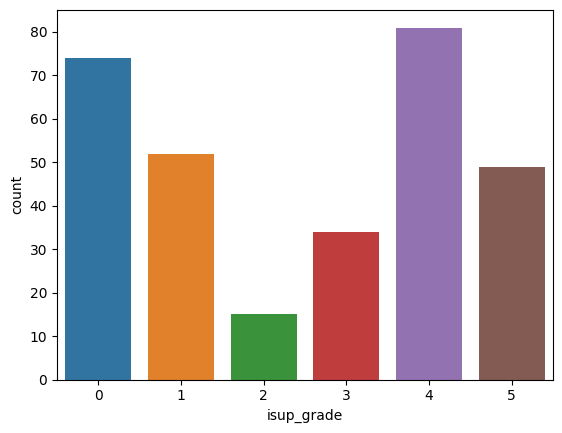

In [19]:
sns.countplot(data = filtered_size_df, x = filtered_size_df['isup_grade'])

In [20]:
# How many images have a maximum size of 10MB?
filtered_size_df_10 = train_df[train_df['image_size_mb'] < 10]
filtered_size_df_10.shape

(849, 6)

In [21]:
filtered_size_df_10['isup_grade'].value_counts()

isup_grade
0    215
4    168
5    137
3    135
1    129
2     65
Name: count, dtype: int64

In [22]:
from PIL import Image

# Base directory to save the organized images
output_base_dir = "/kaggle/working/organized_images"
os.makedirs(output_base_dir, exist_ok=True)

def select_and_save_images_by_class(df, class_column, num_samples, output_base_dir):
    selected_images = []

    for grade in df[class_column].unique():
        grade_df = df[df[class_column] == grade]
        sampled_df = grade_df.sample(n=num_samples, random_state=42)
        
        selected_images.append(sampled_df)
        
        class_dir = os.path.join(output_base_dir, str(grade))
        os.makedirs(class_dir, exist_ok=True)
        
        for _, row in sampled_df.iterrows():
            image_path = row['image_path']
            image_id = row['image_id']
            
            try:
                # Open the image and convert to RGB
                img = Image.open(image_path).convert("RGB")
                
                # Save the image in the class subdirectory
                save_path = os.path.join(class_dir, f"{image_id}.jpg")
                img.save(save_path, format="JPEG")
            except Exception as e:
                # Print a warning and skip the problematic image
                print(f"Skipping image {image_id} due to error: {e}")

    # Combine all successfully sampled DataFrames into one
    return pd.concat(selected_images, ignore_index=True)


In [23]:
# Apply the function to select and save 65 images per class, organized by class label
selected_df = select_and_save_images_by_class(filtered_size_df_10, 'isup_grade', 65, output_base_dir)

# Display the selected DataFrame
selected_df.head()

Skipping image bf990806f56c05b04af0ce599a4541bb due to error: Image size (179306496 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


,image_id,data_provider,isup_grade,gleason_score,image_path,image_size_mb
0,b6b310cbbe944d7bbe95811a2a6178ae,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,6.150142
1,810482a949cbe7f5cd785a1dd9f0122c,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,8.169986
2,c8406145326f8bebae90c13caebc1c6f,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,9.388619
3,29b03a7c58dbdb44f46d936788d8eb66,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,5.222705
4,5037b3b05aec2c96a034ce9301a43326,radboud,3,4+3,/kaggle/input/prostate-cancer-grade-assessment...,3.456538


In [24]:
selected_df['isup_grade'].value_counts()

isup_grade
3    65
4    65
1    65
5    65
0    65
2    65
Name: count, dtype: int64